In [10]:
# Do not change the path of this notebook (do not use %cd)
from PIL import Image

print("GTA5 dataset")
img = Image.open('/home/mateusw/repos/domain_adaptation_semantic_segmentation/data/GTA5/labels/00001.png')
print(img.mode)

print("Cityscapes dataset")
img = Image.open('data/Cityscapes/Cityspaces/gtFine/train/hanover/hanover_000000_000164_gtFine_labelTrainIds.png')
print(img.mode)
print(img.size)

GTA5 dataset
P
Cityscapes dataset
L
(2048, 1024)


# Prepare Enviroment

In [2]:

#!git clone https://github.com/MateusWiteck/domain_adaptation_semantic_segmentation.git


In [11]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 648.3 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (767 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61441 sha256=2e767b3c666c4bfa420400e309c66966a57d77e5d5ff06b89269a7c97d09571e
  Stored in directory: /home/mateusw/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62

In [4]:
# Download Citiescapes Dataset:
#!pip install -q gdown
#!gdown --id 1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2 --output Cityscapes.zip
#!unzip Cityscapes.zip -d domain_adaptation_semantic_segmentation/data/


In [5]:
# Download GTA Dataset:
#!pip install -q gdown
#!gdown --id 1xYxlcMR2WFCpayNrW2-Rb7N-950vvl23 --output GTA5.zip
#!unzip GTA5.zip -d domain_adaptation_semantic_segmentation/data/


# Dataset and Dataloader

Here we should:
- Convert the GTA5 labels to the same format of the Cityscapes dataset (https://github.com/sarrrrry/PyTorchDL_GTA5/blob/master/pytorchdl_gta5/labels.py)
- Create the Datasets class for each one
- Create the DataLoader
- Define the train test val ? division

## Cityscapes

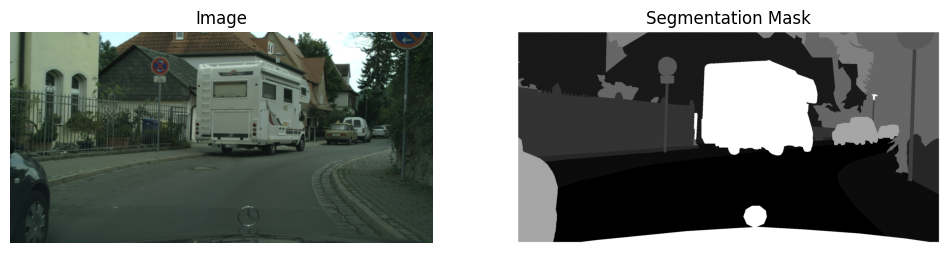

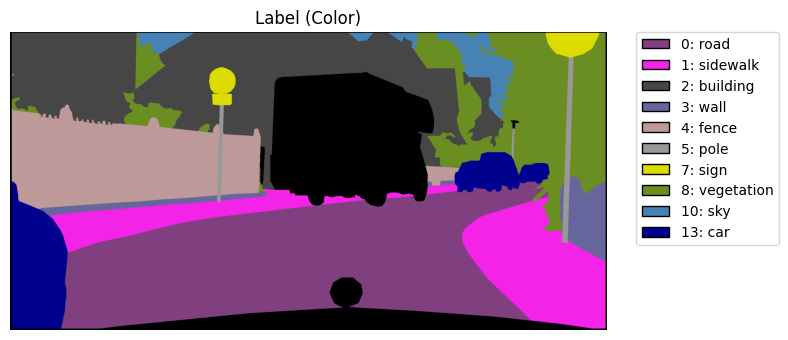

Dataset length: 1572
Image shape: torch.Size([3, 1024, 2048])
Label shape: torch.Size([1024, 2048])


In [5]:
%run datasets/cityscapes.py


## GTA5


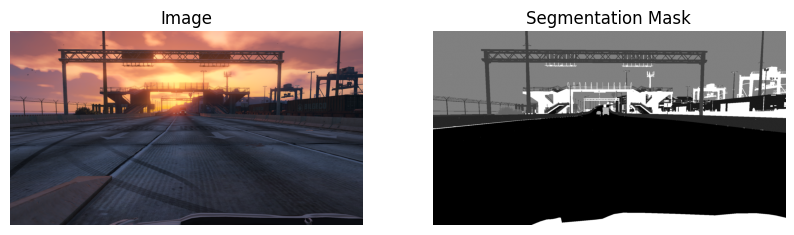

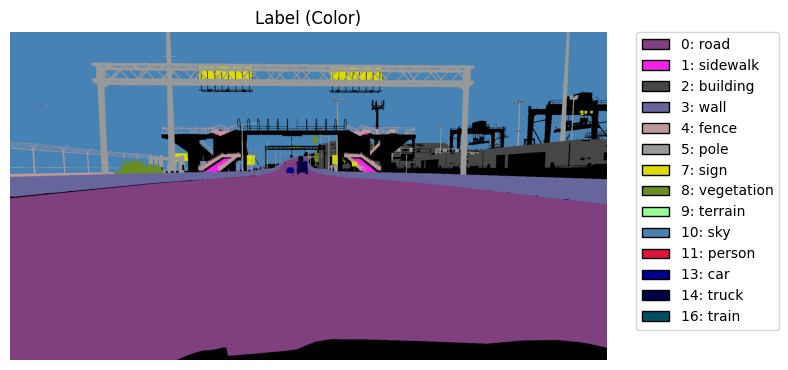

Dataset length: 2500
Image shape: torch.Size([3, 1052, 1914])
Label shape: torch.Size([1052, 1914])


In [4]:
%run datasets/gta5.py



In [3]:
#%cd domain_adaptation_semantic_segmentation/
#!git pull
#!git fetch --all
#%cd ..

# Task 2


## Classic semantic segmentation network.
For this step, you have to train a classic segmentation network (DeepLabV2 [2]) on the Cityscapes dataset.
- Dataset: Cityscapes [5]
- Training epochs: 50
- Training resolution (Cityscapes): 1024x512
- Test resolution (Cityscapes): 1024x512
- Backbone: R101 (pre-trained on ImageNet) [2]
- Semantic classes: 19
- Metrics: Mean Intersection over Union (mIoU) [read this to understand the metrics], latency, FLOPs, number of parameters.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Clean the enviroment
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

from datasets.cityscapes import CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2

# === Hyperparameters ===
num_classes_cs = 19
batch_size_cs = 2
num_workers_cs = 2
learning_rate_cs = 2.5e-4
num_epochs_cs = 40

if torch.cuda.is_available():
    device_cs = torch.device('cuda')
else:
    raise Exception('No GPU available')

# === Dataset & Dataloader ===
transform_cs = transforms.Compose([
    transforms.Resize((64, 64)),  # or smaller
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])
dataset_cs = CityScapes(
    root_dir='data/Cityscapes/Cityspaces',
    split='train',
    transform=transform_cs,
    label_transform=None
)
dataloader_cs = DataLoader(
    dataset_cs,
    batch_size=batch_size_cs,
    shuffle=True,
    num_workers=num_workers_cs,
    pin_memory=True
)

# === Model ===
model_cs = get_deeplab_v2(num_classes=num_classes_cs, pretrain=False)
model_cs = model_cs.to('cuda')

# === Loss & Optimizer ===
criterion_cs = nn.CrossEntropyLoss(ignore_index=255)
"""optimizer_cs = optim.SGD(
    model_cs.optim_parameters(learning_rate_cs),
    lr=learning_rate_cs,
    momentum=0.9,
    weight_decay=0.0005
)"""
optimizer_cs = optim.SGD(
    model_cs.parameters(),
    lr=learning_rate_cs,
    momentum=0.9,
    weight_decay=0.0005
)

# === Training Loop ===
from train import train

metrics_train_task2a = train(
    model_cs, 
    dataloader_cs, 
    optimizer_cs, 
    criterion_cs, 
    device_cs, 
    num_classes_cs, 
    config_cs, 
    "Task2a", 
    project="cityscapes-segmentation"
)


# === Save the model ===
torch.save(model_cs.state_dict(), 'final_models/task2a.pth')

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [5]:

import gc
gc.collect()

# Clean the enviroment
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [7]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121



Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.5 MB/s eta 0:00:0000:010:01
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.2 MB/s eta 0:00:0000:0100:01
INFO: pip is still looking at multiple versions of torchaudio to determine which version

## Real-time semantic segmentation network.
For this step, you have to train a real-time segmentation network (BiSeNet [3]) on the Cityscapes dataset. 
Dataset: Cityscapes [5]
- Training epochs: 50
- Training resolution (Cityscapes): 1024x512
- Test resolution (Cityscapes): 1024x512
- Backbone: ResNet18 (pre-trained on ImageNet) [3]
- Semantic classes: 19
- Metrics: mIoU, latency, FLOPs, number of parameters.

/home/mateusw/repos/domain_adaptation_semantic_segmentation/transformations/random_rotation_transform.py:13: UserWarning: Argument(s) 'border_value, mask_value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipykernel_4709/363435185.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gray', 21)  # 21 = 0 to 20
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5179956].


<PIL.Image.Image image mode=L size=1914x1052 at 0x7521B716EA50>
tensor([[  2,   2,   2,  ...,  10,  10,  10],
        [  2,   2,   2,  ...,  10,  10,  10],
        [  2,   2,   2,  ...,  10,  10,  10],
        ...,
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255]], dtype=torch.uint8)
[[  2   2   2 ...  10  10  10]
 [  2   2   2 ...  10  10  10]
 [  2   2   2 ...  10  10  10]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
Unique label values: [  0   1   2   3   4   5   6   7   8   9  10  11  13  14  17 255]


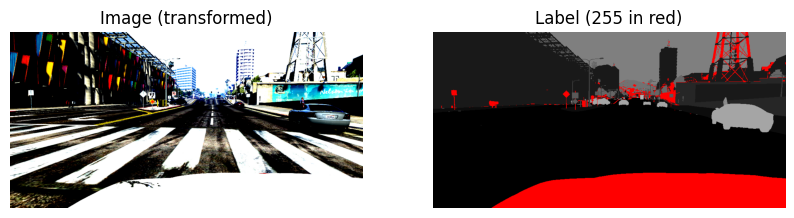

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

from transformations import RandomRotationTransform  # or RandomEraseTransform
from datasets.gta5 import GTA5

# Instantiate transform and dataset
transform = RandomRotationTransform(p=0.5, rotation_limit=90)
dataset_aug = GTA5(root_dir='data/GTA5', transform=transform)

# Load one sample
dataloader = DataLoader(dataset_aug, batch_size=1, shuffle=True)
image, label = next(iter(dataloader))

# Prepare for visualization
image_np = image[0].permute(1, 2, 0).numpy()
label_np = label[0].numpy()
print("final label")
print(label_np)

# Print label range to confirm presence of ignore index
print("Unique label values:", np.unique(label_np))

# Setup colormap for labels: 0–20 normal, 255 shown as red (using 'over' range)
cmap = plt.cm.get_cmap('gray', 21)  # 21 = 0 to 20
cmap.set_over('red')  # Anything > 20 will be red (e.g., 255)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# RGB Image
axes[0].imshow(image_np)
axes[0].set_title('Image (transformed)')
axes[0].axis('off')

# Label with ignore in red
im = axes[1].imshow(label_np, cmap=cmap, vmin=0, vmax=20)
axes[1].set_title('Label (255 in red)')
axes[1].axis('off')

plt.show()
